# Introduction

Goals:
* Determine if certain residue positions move more than others
* Determine if movement is plastic versus rigid body deformation

In [1]:
import os
import itertools
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py3Dmol
import seaborn as sns
from python_pdb.parsers import parse_pdb
from python_pdb.comparisons import rmsd
from tcr_structure_tools.cdr_numbering import assign_cdr_number

In [2]:
DATA_DIR = '/project/koohylab/bmcmaste/projects/tcr-loop-comparison/data/apo-holo-mhc-class-I_refined_aligned'

# Measuring movement for each residue position

## Ca movement

In [3]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

def get_distance(vec1, vec2):
    xx = np.square(vec1[:, 0] - vec2[:, 0])
    yy = np.square(vec1[:, 1] - vec2[:, 1])
    zz = np.square(vec1[:, 2] - vec2[:, 2])
    
    return np.sqrt(xx + yy + zz)

In [4]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
ca_distances = []


for group in os.listdir(DATA_DIR):
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        chains1 = get_chain_assignments(path1)
        chains2 = get_chain_assignments(path2)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(DATA_DIR, group, path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        # Annotate records
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: chains1[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: chains2[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            struct_1_cdr = structure1_df.query("cdr == @cdr_number and chain_type == @chain_type and atom_name == 'CA'")
            struct_2_cdr = structure2_df.query("cdr == @cdr_number and chain_type == @chain_type and atom_name == 'CA'")
            
            # Compute distance
            distance = get_distance(get_coords(struct_1_cdr), get_coords(struct_2_cdr))
            
            # append values to lists
            num_residues = len(distance)
            
            residue_names += struct_1_cdr['residue_name'].to_list()
            residue_seq_ids += struct_1_cdr['residue_seq_id'].to_list()
            residue_insert_codes += struct_1_cdr['residue_insert_code'].to_list()
            
            ca_distances += list(distance)
            
            groups += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues

results_ca = pd.DataFrame({
    'group': groups,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'ca_distance': ca_distances,
})
results_ca

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,TYR,27,None,1.720995
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,None,2.255153
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,None,3.749729
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,None,3.637670
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,None,2.010904
...,...,...,...,...,...,...,...,...,...
8035,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,ASN,113,None,1.001033
8036,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,None,0.825824
8037,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,GLY,115,None,0.376198
8038,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,116,None,0.352412


In [5]:
results_ca['resi'] = results_ca['residue_seq_id'].apply(str) + results_ca['residue_insert_code'].fillna('')

results_ca['struct_1_form'] = results_ca['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results_ca['struct_2_form'] = results_ca['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])

apo_holo_ca = results_ca.query("struct_1_form != struct_2_form")
apo_holo_ca

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,resi,struct_1_form,struct_2_form
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,TYR,27,None,1.720995,27,apo,holo
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,None,2.255153,28,apo,holo
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,None,3.749729,29,apo,holo
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,None,3.637670,36,apo,holo
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,None,2.010904,37,apo,holo
...,...,...,...,...,...,...,...,...,...,...,...,...
8035,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,ASN,113,None,1.001033,113,apo,holo
8036,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,None,0.825824,114,apo,holo
8037,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,GLY,115,None,0.376198,115,apo,holo
8038,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,116,None,0.352412,116,apo,holo


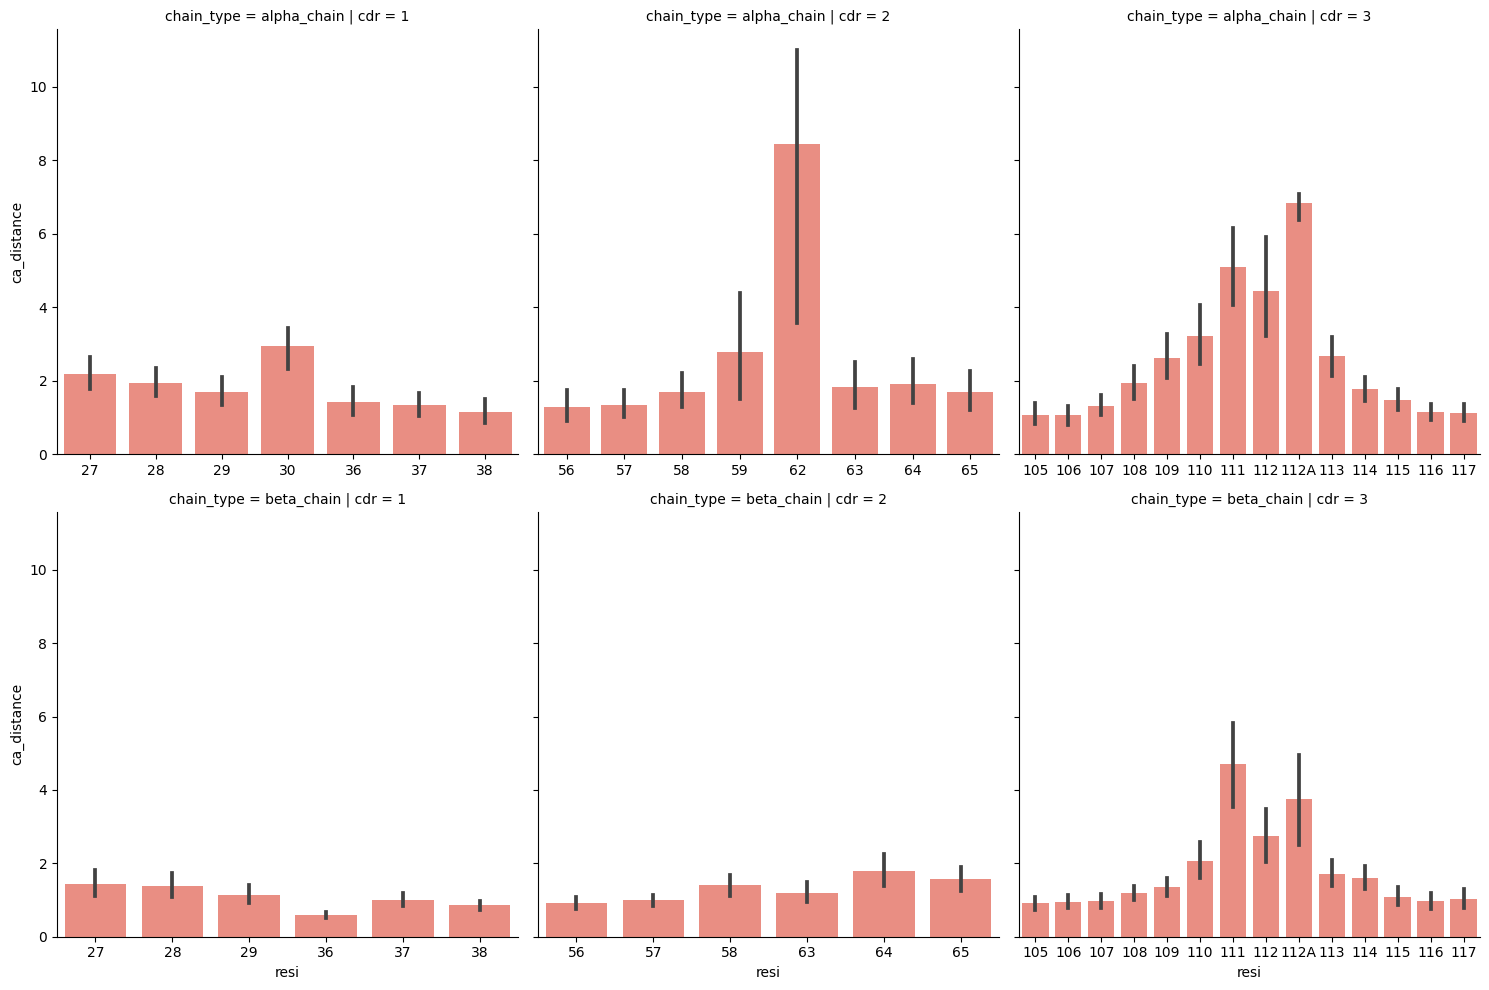

In [6]:
sns.catplot(apo_holo_ca.sort_values('resi'),
            x='resi', y='ca_distance',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Residue RMSD difference

In [7]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
rmsds = []


for group in os.listdir(DATA_DIR):
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        chains1 = get_chain_assignments(path1)
        chains2 = get_chain_assignments(path2)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(DATA_DIR, group, path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        # Annotate records
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: chains1[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: chains2[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            struct_1_cdr = structure1_df.query("cdr == @cdr_number and chain_type == @chain_type")
            struct_2_cdr = structure2_df.query("cdr == @cdr_number and chain_type == @chain_type")
            
            # Compute RMSD for between every residue
            cdr_rmsds = []
            cdr_residue_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            group1 = struct_1_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group2 = struct_2_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            for ((res_name, seq_id, insert_code), res1), (_, res2) in zip(group1, group2):
                try:
                    cdr_rmsds.append(rmsd(get_coords(res1), get_coords(res2)))
                except ValueError:
                    print('Mismatched number of atoms in residue:')
                    print(path1, path2, res_name, seq_id, insert_code)
                    continue
                
                cdr_residue_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)
                
            # append values to lists
            num_residues = len(cdr_rmsds)
            
            residue_names += cdr_residue_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            rmsds += cdr_rmsds
            
            groups += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues


results_rmsd = pd.DataFrame({
    'group': groups,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'rmsd': rmsds,
})
results_rmsd

Mismatched number of atoms in residue:
6vth_DE_apo.pdb 6vrm_DEPA_holo.pdb LYS 115 nan
Mismatched number of atoms in residue:
7n1f_DECA_holo.pdb 7rtr_DECA_holo.pdb GLU 28 nan
Mismatched number of atoms in residue:
7n1f_DECA_holo.pdb 7n1d_AB_apo.pdb GLN 37 nan
Mismatched number of atoms in residue:
7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb GLN 37 nan
Mismatched number of atoms in residue:
7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb GLU 28 nan
Mismatched number of atoms in residue:
3d3v_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
3pwp_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
1qse_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
7amp_AB_apo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
1ao7_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
3qfj_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Mismatched number of atoms in residue:
3

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,rmsd
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLU,38,NaN,2.317881
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,3.431867
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,2.123854
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,2.406584
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,3.983578
...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,2.780664
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,0.510283
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,3.300491
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,NaN,2.705542


In [8]:
results_rmsd['resi'] = results_rmsd['residue_seq_id'].apply(str) + results_rmsd['residue_insert_code'].fillna('')

results_rmsd['struct_1_form'] = results_rmsd['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results_rmsd['struct_2_form'] = results_rmsd['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])

apo_holo_rmsd = results_rmsd.query("struct_1_form != struct_2_form")
apo_holo_rmsd

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,rmsd,resi,struct_1_form,struct_2_form
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLU,38,NaN,2.317881,38,apo,holo
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,3.431867,29,apo,holo
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,2.123854,37,apo,holo
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,2.406584,28,apo,holo
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,3.983578,36,apo,holo
...,...,...,...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,2.780664,110,apo,holo
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,0.510283,117,apo,holo
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,3.300491,108,apo,holo
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,NaN,2.705542,114,apo,holo


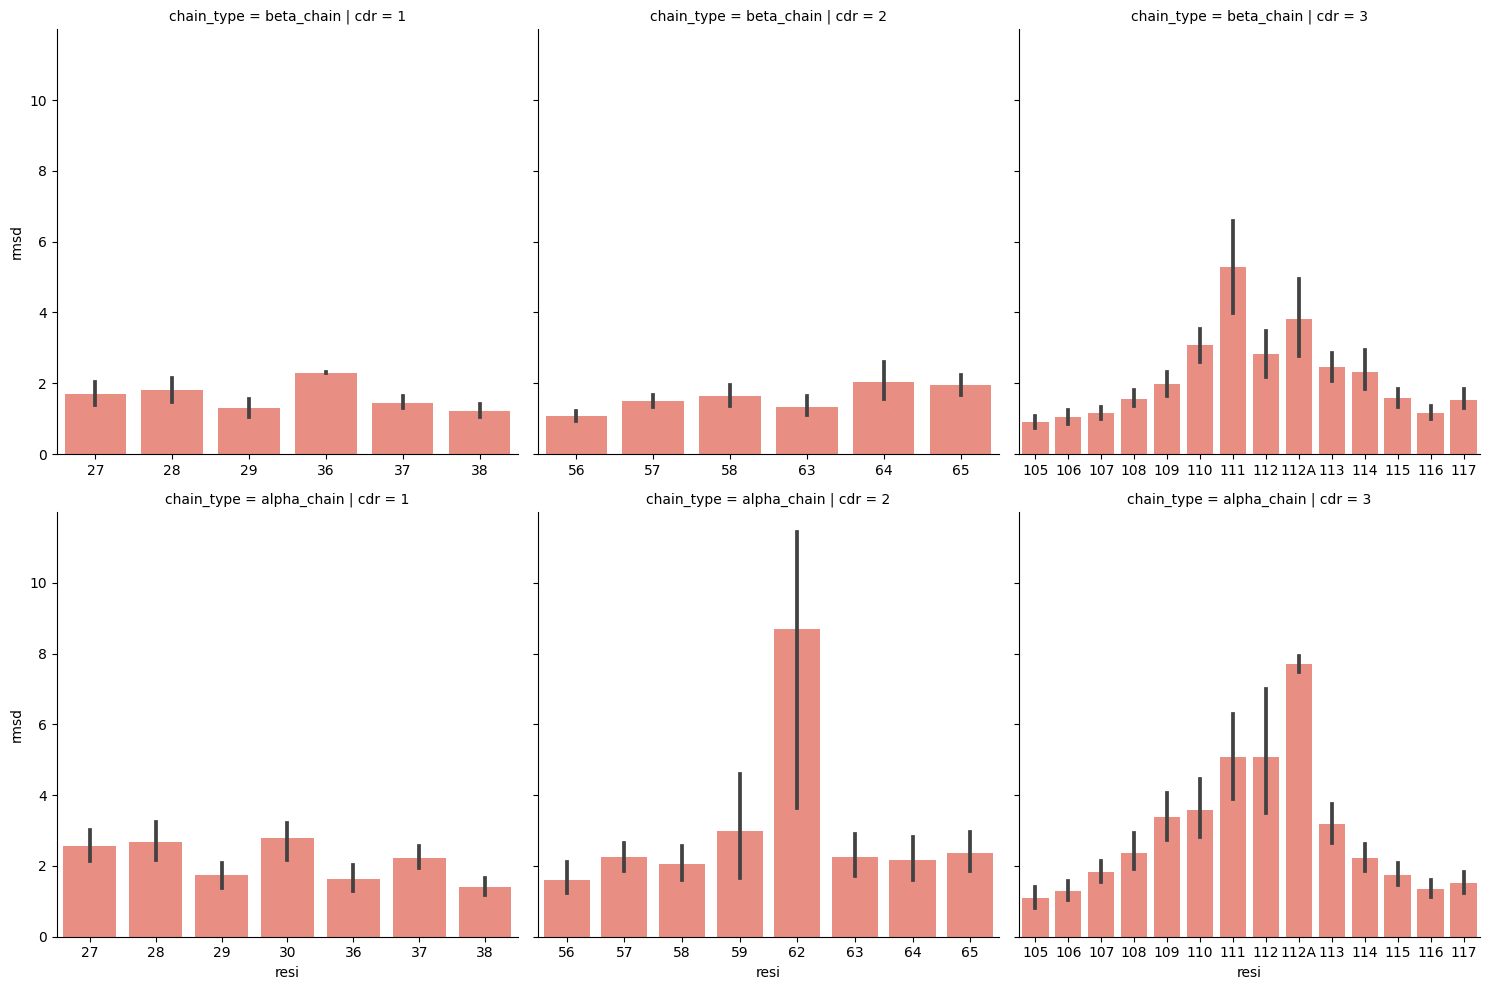

In [9]:
sns.catplot(apo_holo_rmsd.sort_values('resi'),
            x='resi', y='rmsd',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Investigating the CDRA2 position 62

Something odd seems to be going on in this position in all of the plots. Let's get to the bottom of it...

In [29]:
odd_position = apo_holo_ca.query("resi == '62' and chain_type == 'alpha_chain' and cdr == 2").sort_values('ca_distance', ascending=False)
odd_position

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,resi,struct_1_form,struct_2_form
546,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,2ckb_CDQI_holo.pdb,1tcr_AB_apo.pdb,2,alpha_chain,ASP,62,None,11.092819,62,holo,apo
414,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1g6r_ABPH_holo.pdb,1tcr_AB_apo.pdb,2,alpha_chain,ASP,62,None,10.802251,62,holo,apo
634,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,1mwa_ABPH_holo.pdb,1tcr_AB_apo.pdb,2,alpha_chain,ASP,62,None,10.750415,62,holo,apo
678,YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY,2oi9_BCQA_holo.pdb,1tcr_AB_apo.pdb,2,alpha_chain,ASP,62,None,1.164409,62,holo,apo


<Axes: ylabel='Frequency'>

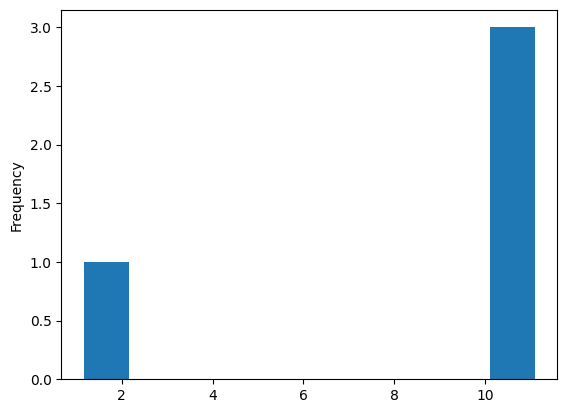

In [23]:
odd_position['ca_distance'].plot.hist()

In [30]:
odd_position.query('ca_distance > 4')['group'].unique()

array(['YSATPY-YYSGDPVV-AVSGFASALT-NNHNN-SYGAGS-ASGGGGTLY'], dtype=object)

Seems to be that this group didn't align properly...

# Meseasuring differences in $\chi$-angles

Do the side chains change conformation as well?

In [11]:
CHI_ATOMS = pd.read_csv('chi-angles.csv', index_col='tlc')

def measure_chi_angle(residue_df: pd.DataFrame) -> float:
    res_name = residue_df.iloc[0]['residue_name']
    chi_atoms = CHI_ATOMS.loc[res_name][['atom_1', 'atom_2', 'atom_3', 'atom_4']].to_list()
    
    atom_positions = [residue_df.query("atom_name == @atom")[['pos_x', 'pos_y', 'pos_z']].iloc[0].to_numpy() for atom in chi_atoms]
    
    b1 = atom_positions[1] - atom_positions[0]
    b2 = atom_positions[2] - atom_positions[1]
    b3 = atom_positions[3] - atom_positions[1]
    
    b1_norm = b1 / np.linalg.norm(b1)
    b2_norm = b2 / np.linalg.norm(b2)
    b3_norm = b3 / np.linalg.norm(b3)
    
    n1 = np.cross(b1_norm, b2_norm)
    n2 = np.cross(b2_norm, b3_norm)
    
    m1 = np.cross(n1, b2_norm)
    
    x = np.dot(n1, n2)
    y = np.dot(m1, n2)
    
    return np.arctan2(x, y)

In [12]:
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []
chi_angle_changes = []


for group in os.listdir(DATA_DIR):
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        chains1 = get_chain_assignments(path1)
        chains2 = get_chain_assignments(path2)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, path1), 'r') as fh:
            structure1_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        with open(os.path.join(DATA_DIR, group, path2), 'r') as fh:
            structure2_df = parse_pdb(fh.read(), silent=True).to_pandas()
        
        # Annotate records
        structure1_df['chain_type'] = structure1_df['chain_id'].map(lambda chain_id: chains1[chain_id])
        structure2_df['chain_type'] = structure2_df['chain_id'].map(lambda chain_id: chains2[chain_id])
        
        structure1_df['cdr'] = structure1_df['residue_seq_id'].map(assign_cdr_number)
        structure2_df['cdr'] = structure2_df['residue_seq_id'].map(assign_cdr_number)
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            struct_1_cdr = structure1_df.query("cdr == @cdr_number and chain_type == @chain_type")
            struct_2_cdr = structure2_df.query("cdr == @cdr_number and chain_type == @chain_type")
            
            # Compute RMSD for between every residue
            cdr_angle_changes = []
            cdr_residue_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            group1 = struct_1_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group2 = struct_2_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            for ((res_name, seq_id, insert_code), res1), (_, res2) in zip(group1, group2):
                if res_name == 'GLY' or res_name == 'ALA':
                    cdr_angle_changes.append(None)
                else:
                    try:
                        cdr_angle_changes.append(measure_chi_angle(res1) - measure_chi_angle(res2))
                    except IndexError:
                        print('Missing atoms needed to calculate chi angle:')
                        print(path1, path2, res_name, seq_id, insert_code)
                        continue
                
                cdr_residue_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)

            # append values to lists
            num_residues = len(cdr_angle_changes)
            
            residue_names += cdr_residue_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            chi_angle_changes += cdr_angle_changes
            
            groups += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues

results_chi = pd.DataFrame({
    'group': groups,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'chi_angle_change': chi_angle_changes,
})
results_chi

Missing atoms needed to calculate chi angle:
6vth_DE_apo.pdb 6vrm_DEPA_holo.pdb LYS 115 nan
Missing atoms needed to calculate chi angle:
7n1f_DECA_holo.pdb 7rtr_DECA_holo.pdb GLU 28 nan
Missing atoms needed to calculate chi angle:
7n1f_DECA_holo.pdb 7n1d_AB_apo.pdb GLN 37 nan
Missing atoms needed to calculate chi angle:
7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb GLN 37 nan
Missing atoms needed to calculate chi angle:
7rtr_DECA_holo.pdb 7n1d_AB_apo.pdb GLU 28 nan
Missing atoms needed to calculate chi angle:
3d3v_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Missing atoms needed to calculate chi angle:
3pwp_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Missing atoms needed to calculate chi angle:
1qse_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Missing atoms needed to calculate chi angle:
7amp_AB_apo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Missing atoms needed to calculate chi angle:
1ao7_DECA_holo.pdb 1qsf_DECA_holo.pdb ARG 113 nan
Missing atoms needed to calculate chi angle:
3qfj_DECA_holo.pdb 1qsf_

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,chi_angle_change
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLU,38,NaN,1.675390
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,NaN
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,-0.070114
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,-2.919778
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,-0.847611
...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,-5.129930
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,-0.274399
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,-1.811693
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,NaN,0.090885


In [13]:
results_chi['resi'] = results_chi['residue_seq_id'].apply(str) + results_chi['residue_insert_code'].fillna('')

results_chi['struct_1_form'] = results_chi['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results_chi['struct_2_form'] = results_chi['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])

results_chi['chi_angle_change_mag'] = results_chi['chi_angle_change'].apply(np.abs)
results_chi['chi_angle_change_deg_mag'] = results_chi['chi_angle_change_mag'].apply(np.degrees)

results_chi

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,chi_angle_change,resi,struct_1_form,struct_2_form,chi_angle_change_mag,chi_angle_change_deg_mag
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLU,38,NaN,1.675390,38,apo,holo,1.675390,95.992791
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,NaN,29,apo,holo,NaN,NaN
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,-0.070114,37,apo,holo,0.070114,4.017258
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,-2.919778,28,apo,holo,2.919778,167.290953
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,-0.847611,36,apo,holo,0.847611,48.564540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,-5.129930,110,apo,holo,5.129930,293.923325
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,-0.274399,117,apo,holo,0.274399,15.721907
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,-1.811693,108,apo,holo,1.811693,103.802337
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,NaN,0.090885,114,apo,holo,0.090885,5.207323


In [14]:
apo_holo_chi = results_chi.query("struct_1_form != struct_2_form")
apo_holo_chi

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,chi_angle_change,resi,struct_1_form,struct_2_form,chi_angle_change_mag,chi_angle_change_deg_mag
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLU,38,NaN,1.675390,38,apo,holo,1.675390,95.992791
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,NaN,NaN,29,apo,holo,NaN,NaN
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,NaN,-0.070114,37,apo,holo,0.070114,4.017258
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,NaN,-2.919778,28,apo,holo,2.919778,167.290953
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,NaN,-0.847611,36,apo,holo,0.847611,48.564540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,110,NaN,-5.129930,110,apo,holo,5.129930,293.923325
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,THR,117,NaN,-0.274399,117,apo,holo,0.274399,15.721907
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,108,NaN,-1.811693,108,apo,holo,1.811693,103.802337
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,NaN,0.090885,114,apo,holo,0.090885,5.207323


/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


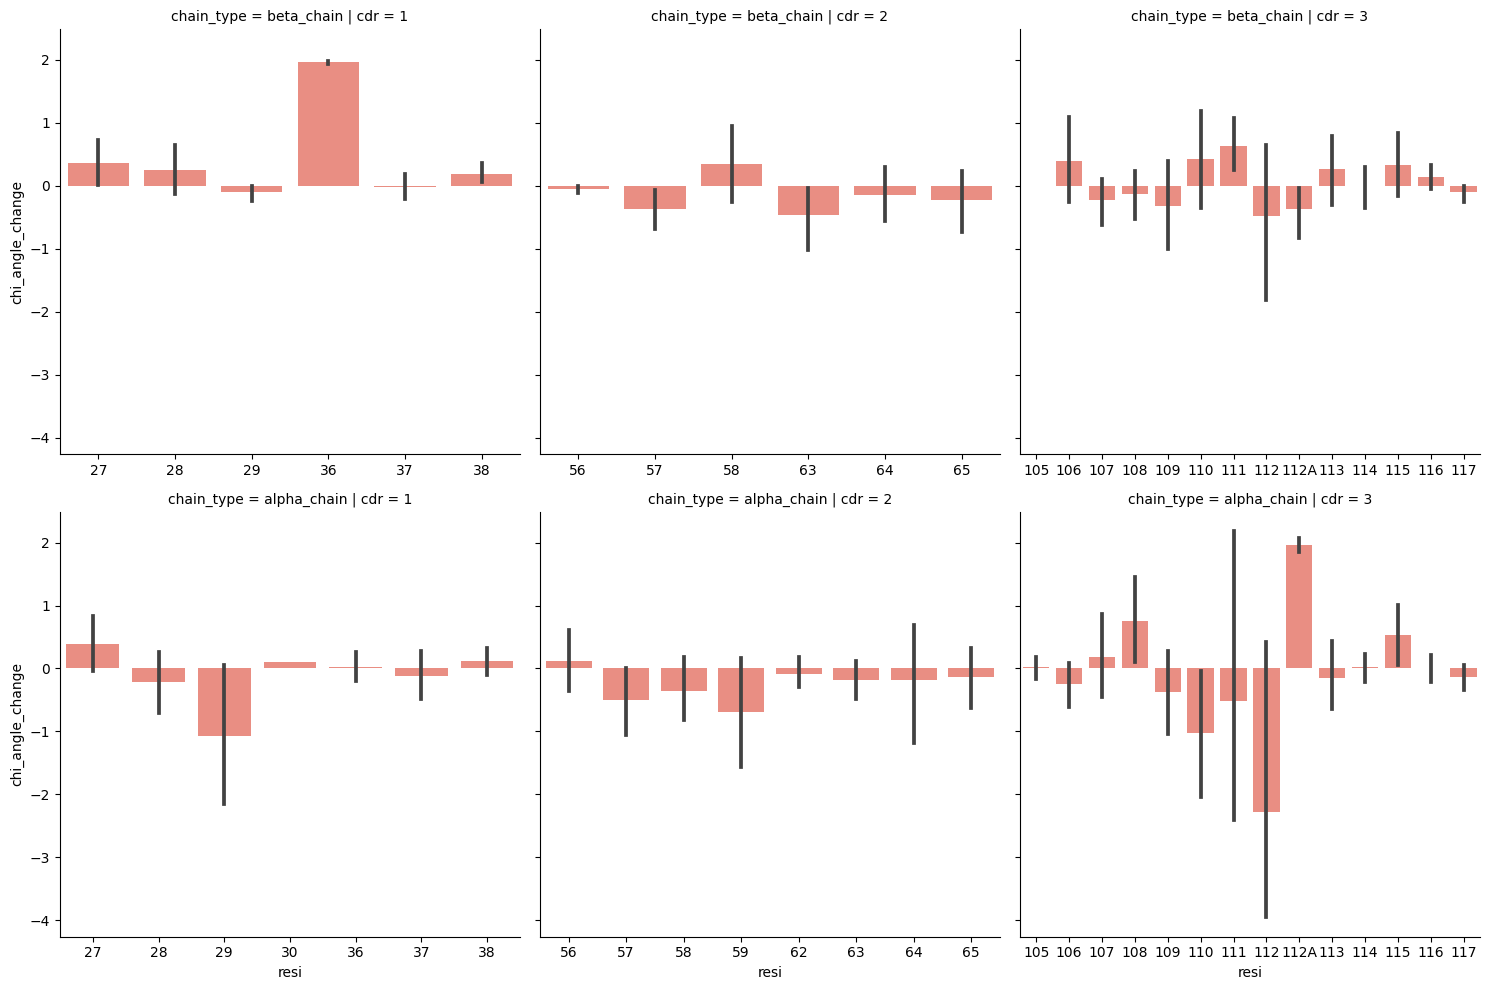

In [15]:
sns.catplot(apo_holo_chi.sort_values('resi'),
            x='resi', y='chi_angle_change',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


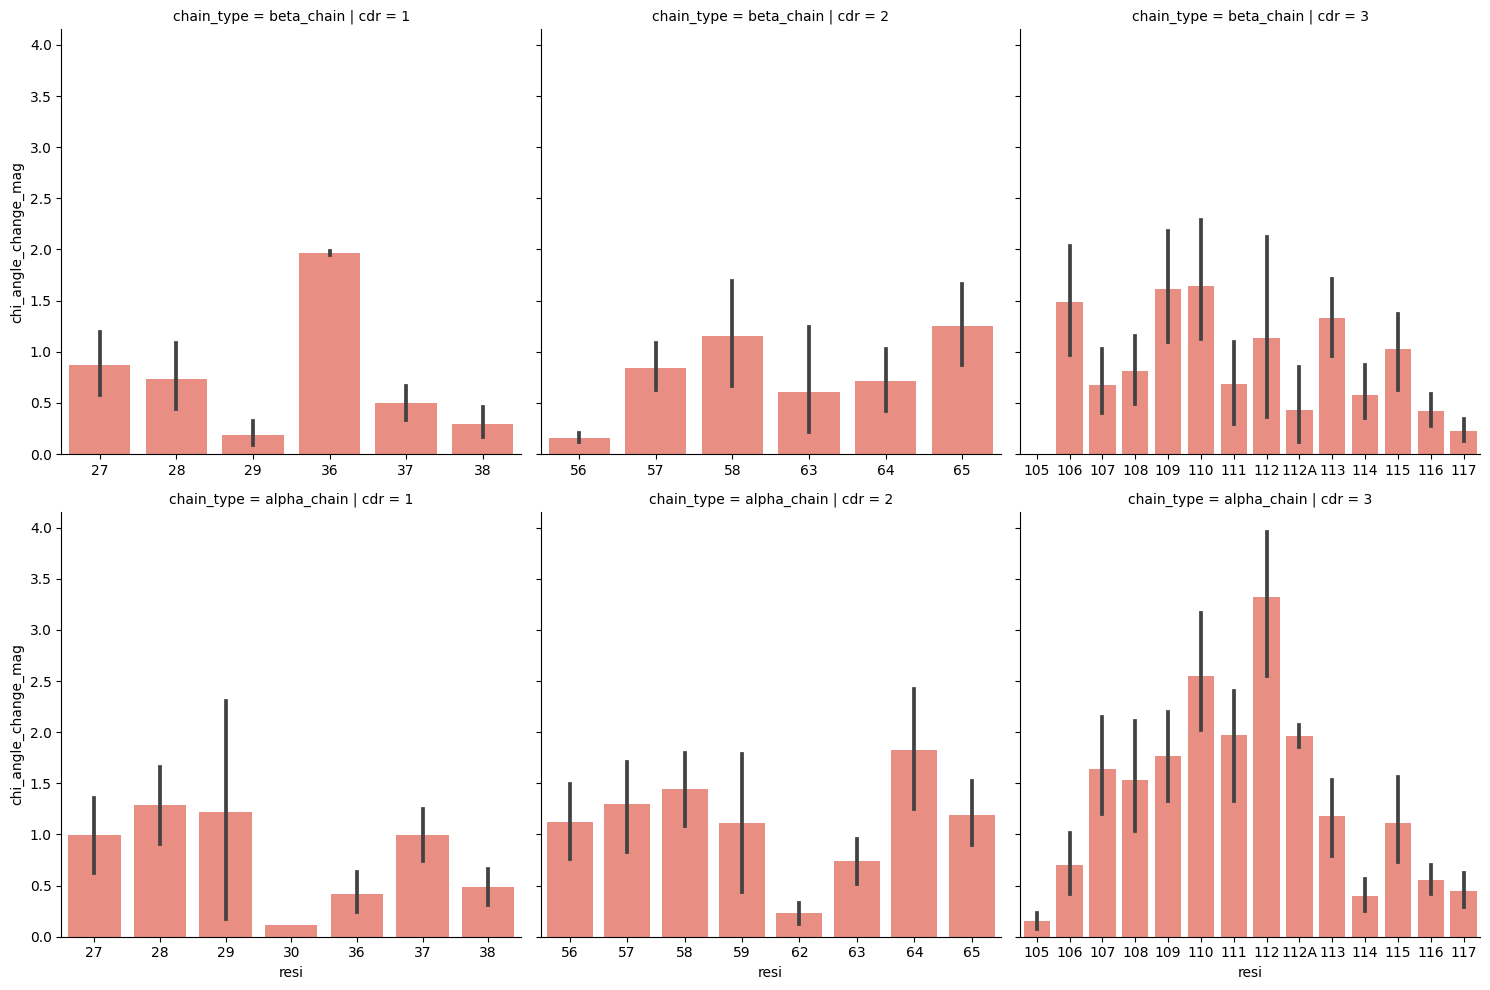

In [16]:
sns.catplot(apo_holo_chi.sort_values('resi'),
            x='resi', y='chi_angle_change_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/package/python-cbrg/current/3.11/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


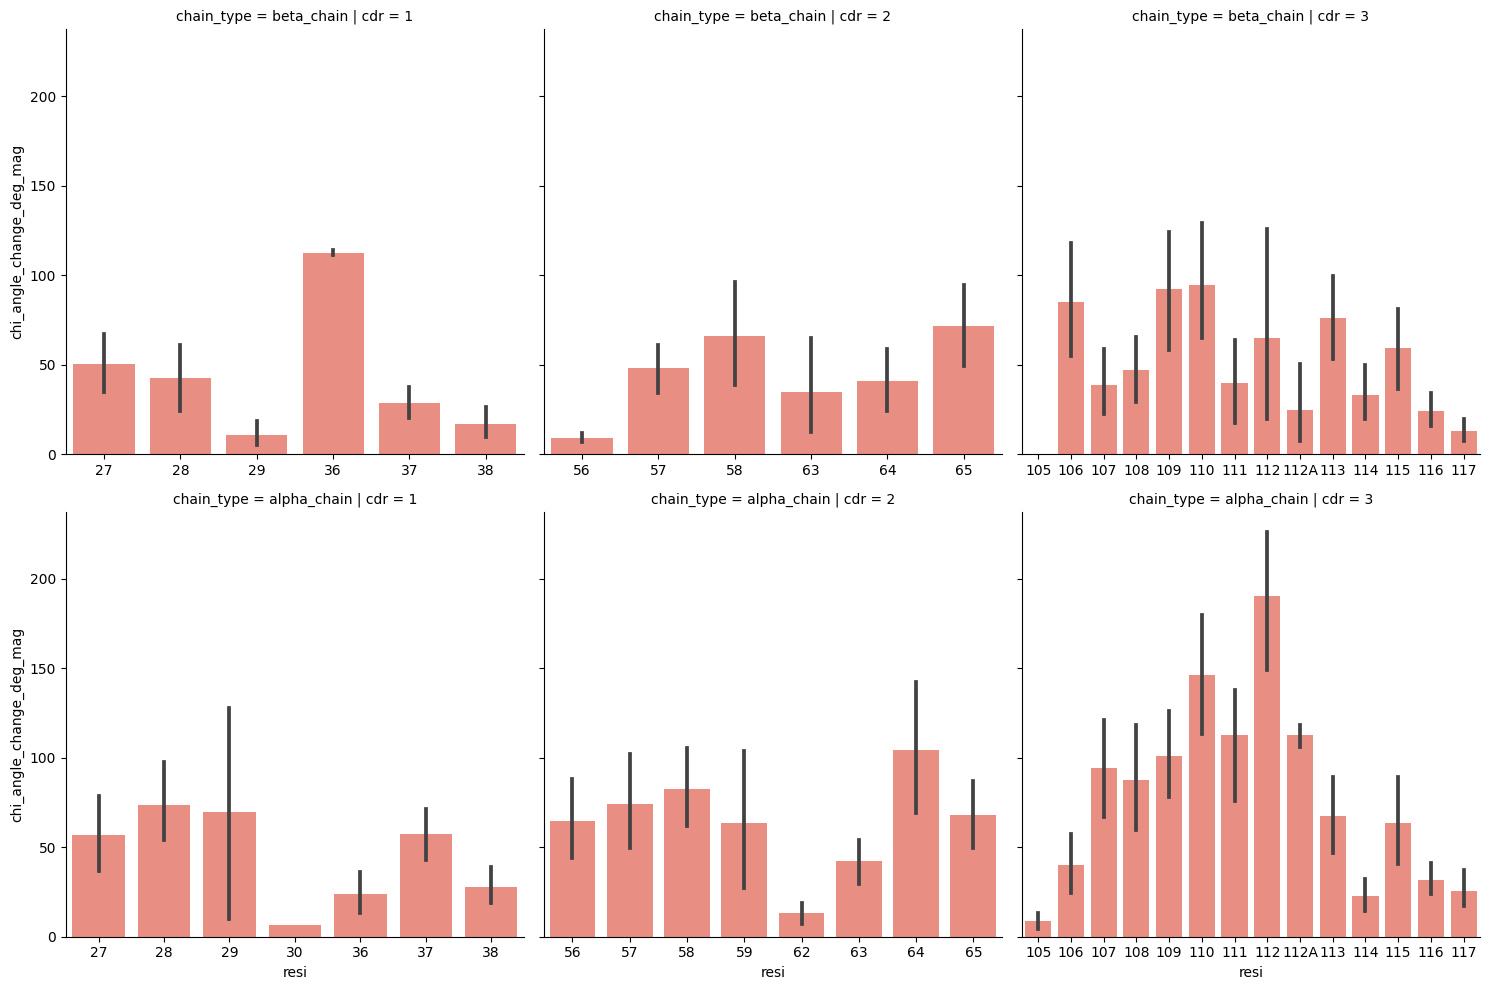

In [17]:
sns.catplot(apo_holo_chi.sort_values('resi'),
            x='resi', y='chi_angle_change_deg_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Correlation Analysis

In [18]:
results = results_ca.merge(results_rmsd).merge(results_chi)
results

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,resi,struct_1_form,struct_2_form,rmsd,chi_angle_change,chi_angle_change_mag,chi_angle_change_deg_mag
0,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,TYR,27,None,1.720995,27,apo,holo,2.706332,-0.150779,0.150779,8.638996
1,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,28,None,2.255153,28,apo,holo,2.406584,-2.919778,2.919778,167.290953
2,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,GLY,29,None,3.749729,29,apo,holo,3.431867,NaN,NaN,NaN
3,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,SER,36,None,3.637670,36,apo,holo,3.983578,-0.847611,0.847611,48.564540
4,YSGSPE-HISR-ALSGFNNAGNMLT-SGHAT-FQNNGV-ASSLGGA...,7n1c_DE_apo.pdb,7n1e_DECA_holo.pdb,1,alpha_chain,PRO,37,None,2.010904,37,apo,holo,2.123854,-0.070114,0.070114,4.017258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,ASN,113,None,1.001033,113,apo,holo,1.233543,2.069872,2.069872,118.594957
8019,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,114,None,0.825824,114,apo,holo,2.705542,0.090885,0.090885,5.207323
8020,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,GLY,115,None,0.376198,115,apo,holo,0.685380,NaN,NaN,NaN
8021,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r7z_AB_apo.pdb,7r80_ABEC_holo.pdb,3,beta_chain,TYR,116,None,0.352412,116,apo,holo,0.982363,-0.295839,0.295839,16.950305


In [19]:
apo_holo = results.query('struct_1_form != struct_2_form').copy()

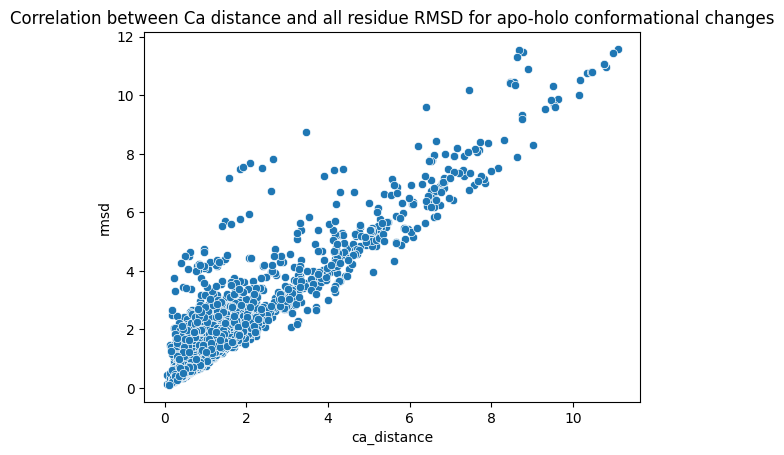

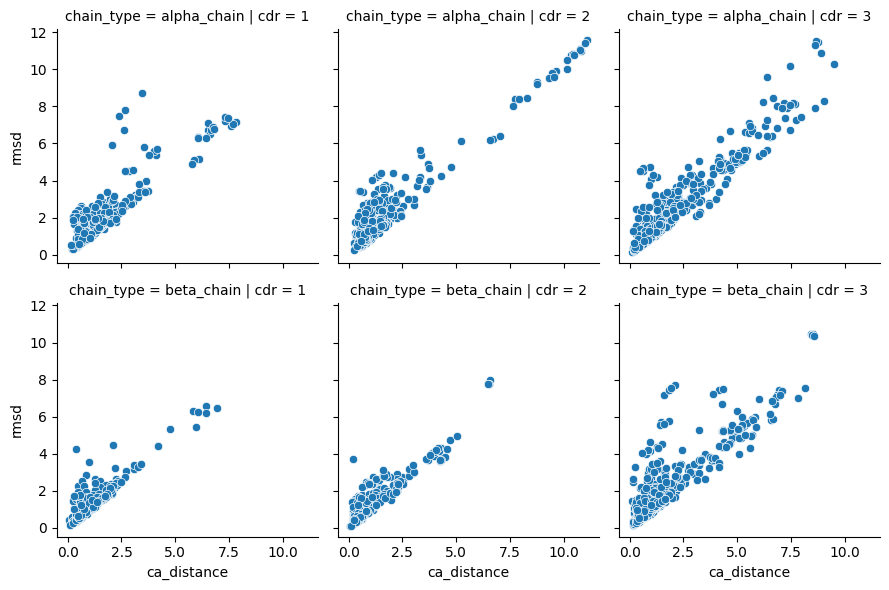

In [20]:
sns.scatterplot(apo_holo, x='ca_distance', y='rmsd')
plt.title('Correlation between Ca distance and all residue RMSD for apo-holo conformational changes')

g = sns.FacetGrid(apo_holo, col='cdr', row='chain_type')
g.map(sns.scatterplot, 'ca_distance', 'rmsd')

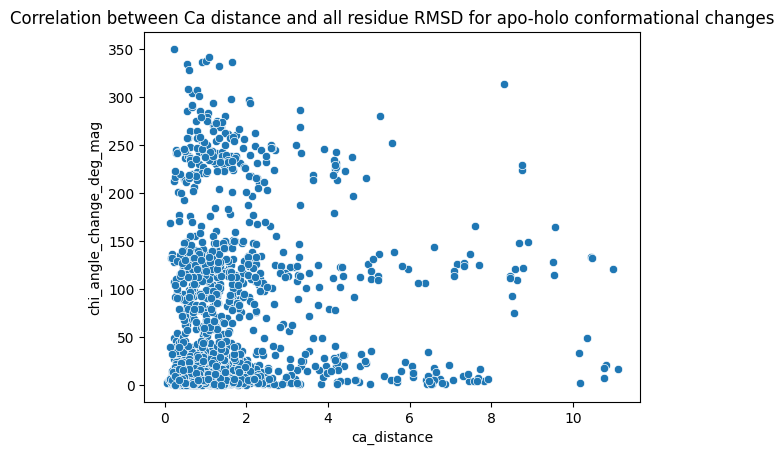

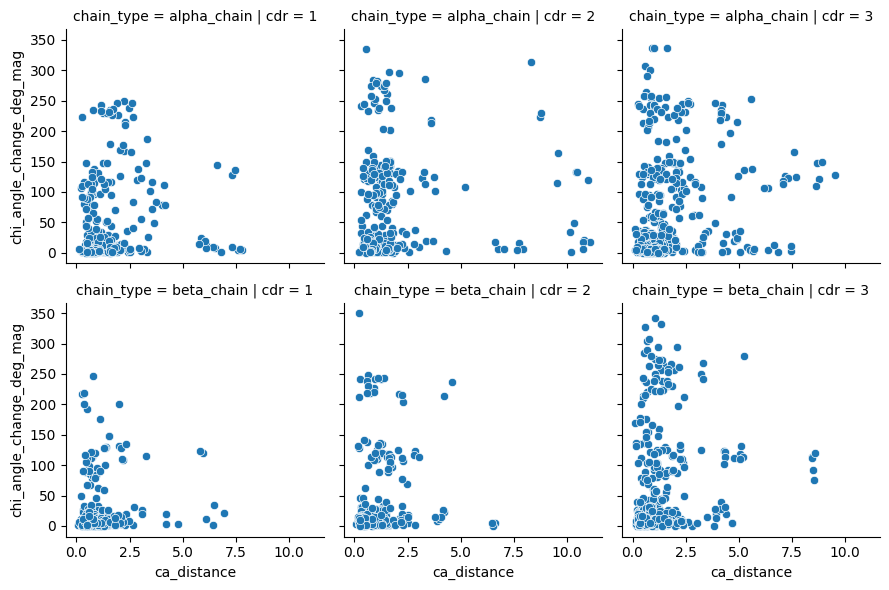

In [21]:
sns.scatterplot(apo_holo, x='ca_distance', y='chi_angle_change_deg_mag')
plt.title('Correlation between Ca distance and all residue RMSD for apo-holo conformational changes')

g = sns.FacetGrid(apo_holo, col='cdr', row='chain_type')
g.map(sns.scatterplot, 'ca_distance', 'chi_angle_change_deg_mag')